# Kinematic Control

*License: CC-BY-NC-SA 4.0*

*Author: Murilo M. Marinho (murilo.marinho@manchester.ac.uk)*

## Pre-requisites
The user of this notebook is expected to have prior knowledge in
- All the content and pre-requisites of lessons 1, 2, 3, and 4.

## I found an issue
Thank you! Please report it at https://github.com/MarinhoLab/OpenExecutableBooksRobotics/issues

#### Latex Macros
$\providecommand{\myvec}[1]{{\mathbf{\boldsymbol{{#1}}}}}$
$\providecommand{\mymatrix}[1]{{\mathbf{\boldsymbol{{#1}}}}}$

# Pre-requisites

In [28]:
%%capture
%pip install numpy
%pip install numpy --break-system-packages
%pip install roboticstoolbox-python
%pip install roboticstoolbox-python --break-system-packages
%pip install matplotlib
%pip install matplotlib --break-system-packages

# Imports

In [29]:
%matplotlib inline
import numpy as np
import spatialmath as sm
import matplotlib.pyplot as plt
from math import pi, sin, cos

# Suggested exercises
- Try to modify the code below to calculate the control action for a:
1. PP robot
2. RP robot

# 2 DoF planar robot (RR)

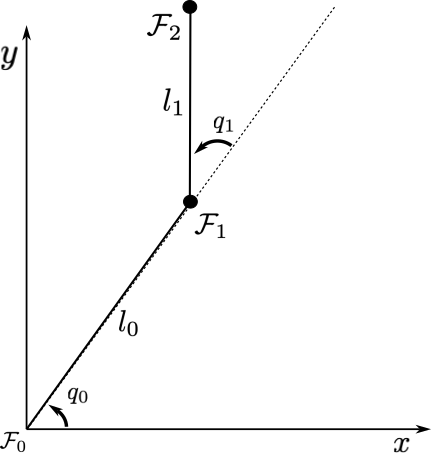

For the 2-DoF planar robot shown in the figure, let $q_0\triangleq q_0(t)$, $q_1\triangleq q_1(t)$, $l_{0}$, $l_{1} \in \mathbb{R}$ be the parameters to calculate

$$\mymatrix{H}^{0}_{2}( q_0, l_{0},q_1,l_{1}) \in SE(2),$$

that is, the forward kinematics model of the 2 DoF planar manipulator with configuration space given by 

$$\myvec{q} = \left[\begin{array}{ccc}
         q_0 \\
         q_1
        \end{array}\right].$$

and given the analytical Jacobian below

$$\dot{\myvec{x}}=\mymatrix{J} \dot{\myvec{q}}$$

where 

$$\myvec{x} = \left[\begin{array}{ccc}
         p_{x} \\
         p_{y} \\
         \phi_{z}
        \end{array}\right],$$

in which $p_{x}$, $p_{y}$, and $\phi_{z}$ are, respectively, the $x$-axis position, the $y$-axis position, and the $z$-axis angle of $\mathcal{F}_{2}$. Notice that $\dot{l}_{0}=\dot{l}_{1}=0$. 

### Consider the forward kinematics model calculated as in the past lesson

$$\mymatrix{H}^{0}_{2} = \left[\begin{array}{ccc}
         \cos{(q_0 + q_1)} & -\sin{(q_0 + q_1)} & l_{0}\cos{q_0} + l_{1}\cos{(q_0 + q_1)}\\
         \sin{(q_0 + q_1)} & \cos{(q_0 + q_1)}  & l_{0}\sin{q_0} + l_{1}\sin{(q_0 + q_1)}\\
         0                 & 0                  & 1
        \end{array}\right].$$

This means that, from inspection,

$$p_{x}=l_{0}\cos{q_0} + l_{1}\cos{(q_0 + q_1)}$$
$$p_{y}=l_{0}\sin{q_0} + l_{1}\sin{(q_0 + q_1)}$$
$$\phi_{z} = q_0 + q_1.$$

With those, we can obtain the task space values with a function called `planar_robot_fkm` so that it can be easily reused

In [30]:
def planar_robot_fkm(q: np.array) -> np.array:
    """
    q: The configuration space values in radians.
    returns the x, this, the current task space value where x = [p_x p_y phi_z]^T.
    """
    l_0: float = 0.2 # The robot parameters. They don't change in time, so they are constant here.
    l_1: float = 0.1

    q_0 = q[0] # Just to make it more readable.
    q_1 = q[1] 

    p_x = l_0 * cos(q_0) + l_1 * cos(q_0 + q_1)
    p_y = l_0 * sin(q_0) + l_1 * sin(q_0 + q_1)
    phi_z = q_0 + q_1

    return np.array([p_x,
                     p_y,
                     phi_z])


### Consider the analytical Jacobian

We first calculate the Jacobian by hand, because programatically there's nothing for you to do yet. As we did in class, here is the Jacobian

$$\mymatrix{J} = \left[\begin{array}{ccc}
         -l_{0}\sin{q_0} - l_{1}\sin{(q_0 + q_1)} & -l_{1}\sin{(q_0 + q_1)} \\
         l_{0}\cos{q_0} + l_{1}\cos{(q_0 + q_1)} & l_{1}\cos{(q_0 + q_1)}  \\
         1                 & 1                  
        \end{array}\right].$$

We transform this Jacobian calculation into the function `planar_robot_jacobian` shown below

In [31]:
def planar_robot_jacobian(q: np.array) -> np.array: 
    """
    q: The configuration space values in radians.
    returns the 3x2 Jacobian mapping [q_0 q_1]^T to [px py phi_z]^T.
    """
    l_0: float = 0.2 # The robot parameters. They don't change in time, so they are constant here.
    l_1: float = 0.1

    q_0 = q[0] # Just to make it more readable.
    q_1 = q[1] 

    J_1_1 = -l_0 * sin(q_0) - l_1 * sin(q_0 + q_1)
    J_1_2 = -l_1 * sin(q_0  + q_1)
    J_2_1 =  l_0 * cos(q_0) + l_1 * cos(q_0 + q_1)
    J_2_2 =  l_1 * cos(q_0 +  q_1)
    J_3_1 = 1
    J_3_2 = 1

    return np.array(
                [[J_1_1, J_1_2],
                 [J_2_1, J_2_2],
                 [J_3_1, J_3_2]]
        )

## Kinematic Control

### 1. Define an error function

We usually use

$$\tilde{\myvec{x}}= \myvec{x} - \myvec{x}_d$$

that can be implemented as the function `get_error` below

In [32]:
def get_error(x: np.array, xd: np.array) -> np.array:
    """In this case, we use the difference as the error.
    x: current task-space vector.
    xd: desired task-space vector.
    """
    return x - xd

### 2. Define the control loop

We resort to the following control law

$$\myvec{u} = -\eta \mymatrix{J}^{+}\tilde{\myvec{x}}$$

that can be easily implemented. Notice that we can resort to `np.linalg.pinv()` to perform the pseudo inversion. According to its [documentation](https://numpy.org/doc/2.2/reference/generated/numpy.linalg.pinv.html), it implements the Moore-Penrose pseudo-inversion based on the Singular Value Decomposition of all "large" singular values.


For the control loop itself, we use all previous functions. The idea here is to show that the norm of the error decreases with the control action. The desired task space vector will not always be achievable. Nonetheless, we can show, as below, that the control action reduces the task-space error, $\tilde{\myvec{x}}$.

Let $\eta=0.5$ be the controller gain and $T=0.001$ be the sampling time. In addition, let the manipulator start at $t=0$ with $q_0=q_1=0$.


In [33]:
eta: float = 0.5 # Controller proportional gain
T:float = 0.001 # Sampling time
# Define initial values for the joint positions
q_0 = 0.0
q_1 = 0.0
q = np.array([q_0,q_1])


# A desired task-space value, defined by the problem at hand
xd = np.array([0.1,0.1,pi/10])
print(f"xd = {xd}")

# Define a stop criteria, in this case let's control for 10 seconds
t:float = 0 # Current time

# Lists to store the value of each control iteration
x_tilde_norm_list = []
t_list = []

while t < 10:
    # Calculate task-space value, x
    x = planar_robot_fkm(q)
    # Calculate task-space error, x_tilde
    x_tilde = get_error(x, xd)
    # Get the Jacobian
    J = planar_robot_jacobian(q)
    # Invert the Jacobian, for example, with numpy's implementation of it
    J_inv = np.linalg.pinv(J)
    # Calculate the control action
    u = -eta * J_inv @ x_tilde
    
    ## Store values in the list so that we can print them later
    x_tilde_norm_list.append(np.linalg.norm(x_tilde))
    t_list.append(t)

    ## Variable updated for the next loop
    q = q + u * T # Update law using the sampling time
    t = t + T    

xd = [0.1        0.1        0.31415927]


# Optional: Print the data

To help visualise the behavior of the controller, you can optionally plot the data. These data show that with the defined parameters the qualitative behavior is very close to exponential decay. 

However the error does not converge to zero, meaning that the manipulator did not reach its target. Indeed, this is usually the case when the target is outside the reach of the manipulator or all task-space desired values cannot be simultenously satisfied.

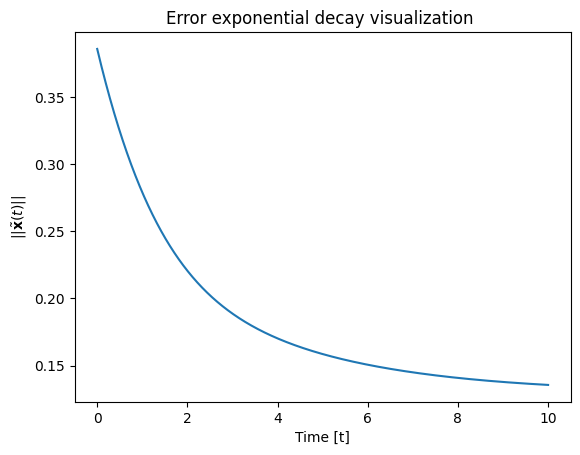

In [ ]:
plt.plot(t_list,x_tilde_norm_list)
plt.title('Error exponential decay visualization (Moore-Penrose)')
plt.xlabel("Time [t]")
plt.ylabel("$||\\tilde{ \\bf{x} } (t) ||$")
plt.show()

# Alternative Jacobian Inversion Strategies

The SVD-based Moore-Penrose pseudo-invese is a common strategy for matrix inversion. It is important to notice, however, that is is not the only one. In addition, it is not always the best choice for robot control.

Another common strategy is the so-called damped pseudo-inverse, described below. It is usually the easiest choice to embbed robustness to singularities in the controller.

$$\mymatrix{J}^{\dagger}=\mymatrix{J}^T\left(\mymatrix{J}\mymatrix{J}^T + \lambda^2\mymatrix{I}\right)^{-1},$$

defined in the function `damped_pseudo_inverse()` below in which we call $\lambda$ as the variable `damping`

In [ ]:
def damped_pseudo_inverse(A: np.array, damping: float = 0.01):
    """Calculates the damped pseudo inverse of A"""
    if damping == 0:
        raise Exception(f"Damping is {damping} but should be different from zero")
    
    return A.T @ np.linalg.inv(A @ A.T + (damping ** 2) * np.eye(A.shape[0]))

with that, our controller becomes

xd = [0.1        0.1        0.31415927]


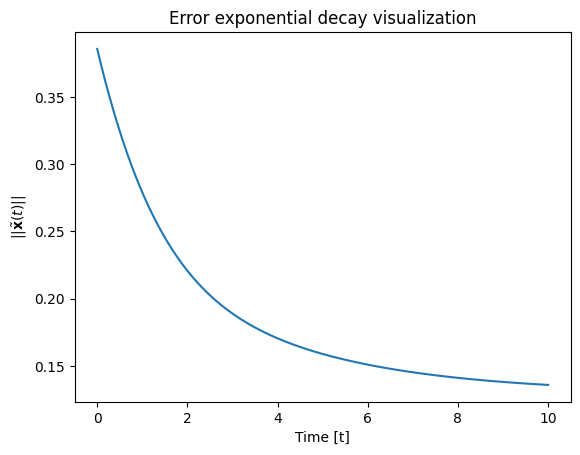

In [ ]:
eta: float = 0.5 # Controller proportional gain
T:float = 0.001 # Sampling time
# Define initial values for the joint positions
q_0 = 0.0
q_1 = 0.0
q = np.array([q_0,q_1])


# A desired task-space value, defined by the problem at hand
xd = np.array([0.1,0.1,pi/10])
print(f"xd = {xd}")

# Define a stop criteria, in this case let's control for 10 seconds
t:float = 0 # Current time

# Lists to store the value of each control iteration
x_tilde_norm_list = []
t_list = []

while t < 10:
    # Calculate task-space value, x
    x = planar_robot_fkm(q)
    # Calculate task-space error, x_tilde
    x_tilde = get_error(x, xd)
    # Get the Jacobian
    J = planar_robot_jacobian(q)
    # Invert the Jacobian using the damped pseudo-inverse
    J_inv = damped_pseudo_inverse(J)
    # Calculate the control action
    u = -eta * J_inv @ x_tilde
    
    ## Store values in the list so that we can print them later
    x_tilde_norm_list.append(np.linalg.norm(x_tilde))
    t_list.append(t)

    ## Variable updated for the next loop
    q = q + u * T # Update law using the sampling time
    t = t + T    

# (Optional) plot the data
plt.plot(t_list,x_tilde_norm_list)
plt.title('Error exponential decay visualization (Damped Pseudo-inverse)')
plt.xlabel("Time [t]")
plt.ylabel("$||\\tilde{ \\bf{x} } (t) ||$")
plt.show()